### Nesse dia vamos simular a qualidade de nosso modelo de recomendação, realizando um Teste A/B para os dados da [Kaggle](https://www.kaggle.com/datasets/zhangluyuan/ab-testing), dataset que simula exatamente um teste A/B para dois sites distintos com base nas conversões dos clientes. 

### O intuito desse dia é praticar estatística para a avaliação e validação de modelos.

# **Dia 6**

## **Introdução**

O cinema **Veja Mais** contatou nossos serviços para a implementação de nosso mais novo modelo de recomendação que foi anunciado recentemente. Ele gostaría de que implementássemos nosso modelo em seu site de vendas de ingressos para a recomendação de filmes para seus clientes consolidados, mas teve dúvidas quanto à sua eficiência, desta forma disponibilizamos 30 dias gratuitos para o teste do modelo. Após o período vigente, a **Veja Mais** solicitou uma análise estatística dos dados para avaliação do seu resultado.

Nosso intuito é validar, com base nas conversões, se nosso modelo apresentou uma taxa de mais conversões dentro do site, com isso aplicaremos visualização nos dados e testes estatísticos comparando a quantidade de vendas para o site com e sem nosso modelo.

Para este trabalho utilizaremos as seguintes bibliotecas:

- Pandas
- Matplotlib
- Seaborn
- Statsmodels
- Os
- Requests
- Zipfile

As primeiras 3 bibliotecas são para a extração, tratamento e visualização de nosso dados, o **Statsmodels** servirá para aplicação de teste estatíticos e as 3 últimas são para o *download* dos nossos dados do site da **Veja Mais**.

In [203]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import requests
import zipfile

## **Extração dos Dados**

In [204]:
# zip_url = 'https://www.kaggle.com/api/v1/datasets/download/zhangluyuan/ab-testing'
# zip_path = '../DS_Dia_6/dia_6.zip'
# extract_path = '../DS_Dia_6'

# response = requests.get(zip_url)

# with open(zip_path, 'wb') as f:
#     f.write(response.content)

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# os.listdir(extract_path)

In [205]:
df = pd.read_csv('../DS_Dia_6/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


## **Tratamento dos Dados**

Vamos verificar se em nosso dataset não temos dados nulos, dados duplicados ou inconsistências tanto nos dados como em seus tipos.

In [206]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


A quantidade total dos dados são de 294478 entradas, com nenhum problema de dados nulos, mas com problemas de tipo de dados para a coluna `timestamp`

In [207]:
for coluna in ['group', 'landing_page', 'converted']:
    print('----' * 6)
    print(df[coluna].unique())

------------------------
['control' 'treatment']
------------------------
['old_page' 'new_page']
------------------------
[0 1]


Vemos que para as colunas categóricas `group`, `landing_page` e `converted` não apresentam nem problemas com dados vazios.

In [208]:
df.duplicated().sum()

np.int64(0)

In [209]:
df['user_id'].duplicated().sum()

np.int64(3894)

Vemos que para os dados em si não apresentam dados duplicados, mas vemos que existem usuários que apareceram mais de uma vez em nosso DataFrame. Precisamos tratar isso para não termos imprecisões para quando aplicarmos estatística nos dados, uma vez que um usuário pode ter entrado no site sem nosso modelo, ter apresentado interesse em um filme e ter voltado mais tarde, mas aparecendo no site com nosso modelo, criando uma falsa aparência de melhora nas vendas.

Com isso iremos tratar o tipo da coluna `timestamp` e retirar os usuário repetidos.

In [210]:
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       294478 non-null  int64         
 1   timestamp     294478 non-null  datetime64[ns]
 2   group         294478 non-null  object        
 3   landing_page  294478 non-null  object        
 4   converted     294478 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 11.2+ MB


In [211]:
ids_velho = df[df['landing_page'] == 'old_page'][['user_id']]
ids_novo = df[df['landing_page'] == 'new_page']['user_id']
ids_duplicados = ids_velho[ids_velho['user_id'].isin(ids_novo)]

df = df[~df['user_id'].isin(ids_duplicados['user_id'])]
df = df.reset_index(drop=True)
df.shape

(290482, 5)

Após nosso tratamento, vamos fazer uma visualização gráfica dos dados.

## **Visualização Gráfica**

Avaliaremos nossos dados plotando um gráfico de barras para comparar as conversões entre a velha página com a nova página.

Também utilizaremos um gráfico de linhas para ver como foi as vendas ao longo desse 30 dias.

/tmp/ipykernel_875/2777094728.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels(['Velha Página', 'Nova Página'], fontsize=13)


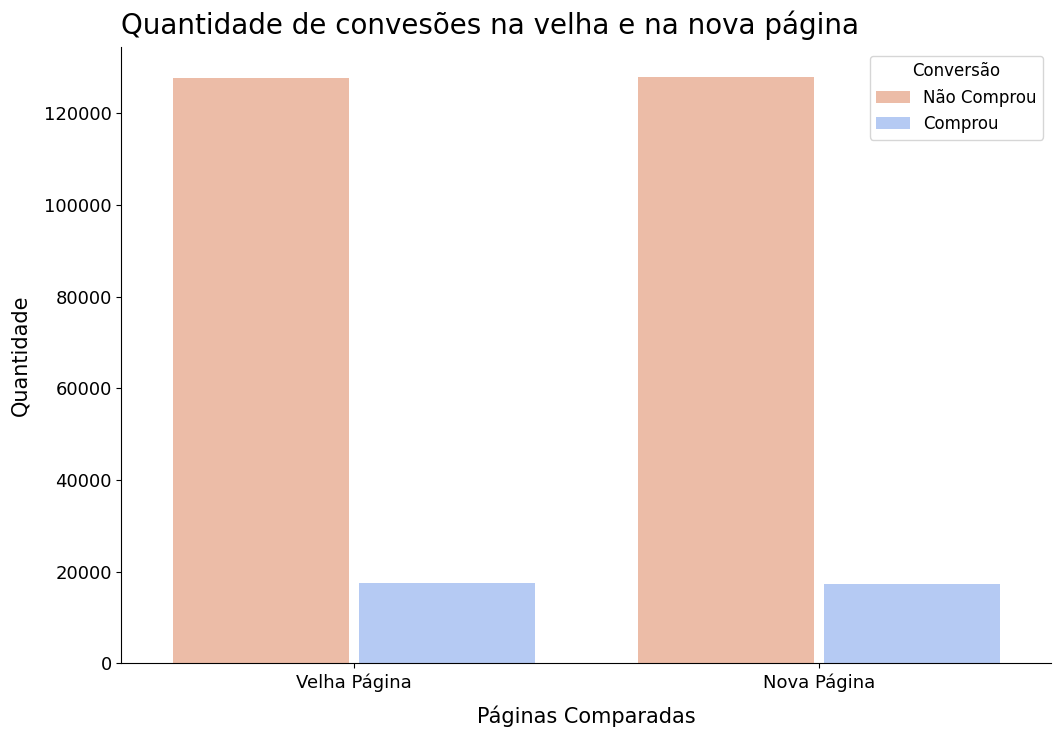

In [212]:
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.countplot(df, x='landing_page', palette='coolwarm_r', hue='converted', gap=0.05)

ax.set_title('Quantidade de convesões na velha e na nova página', fontsize=20, loc='left', pad=10)

ax.set_xlabel('Páginas Comparadas', fontsize=15, labelpad=10)
ax.xaxis.set_ticklabels(['Velha Página', 'Nova Página'], fontsize=13)

ax.set_ylabel('Quantidade', fontsize=15, labelpad=10)
ax.yaxis.set_tick_params(labelsize=13)

ax.legend(bbox_to_anchor=(1, 1), title='Conversão', title_fontsize=12, labels=['Não Comprou', 'Comprou'], fontsize=12)

sns.despine()

plt.show()

Vemos nosso dados apresentam um grande similaridade em quantidade de pessoas avaliadas em cada página, com um valor tão próximo assim não podemos concluir nada sobre se tivemos ou não uma melhora nas vendas.

Essas informações sugerem que precisamos aplicar testes estatísticos para nossos dados.

In [213]:
conversao_dados = df.query('converted == 1').copy()
conversao_dados = conversao_dados.drop(['user_id', 'group', 'converted'], axis=1)
conversao_dados['landing_page'] = conversao_dados['landing_page'].replace({'old_page': 'velha', 'new_page': 'nova'})

conversao_dados['Dia'] = conversao_dados['timestamp'].dt.day
conversao_dados = conversao_dados.drop('timestamp', axis=1)

conversao_dados = conversao_dados.groupby('Dia').value_counts()
conversao_dados = conversao_dados.to_frame()

conversao_dados.head()

count
Dia landing_page       
2   velha           357
    nova            339
3   nova            754
    velha           749
4   velha           797

Tratamento para utilizar no gráfico de linhas.

/tmp/ipykernel_875/3637530884.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.xaxis.set_ticklabels([5, 10, 15, 20, 25, 30], fontsize=13)


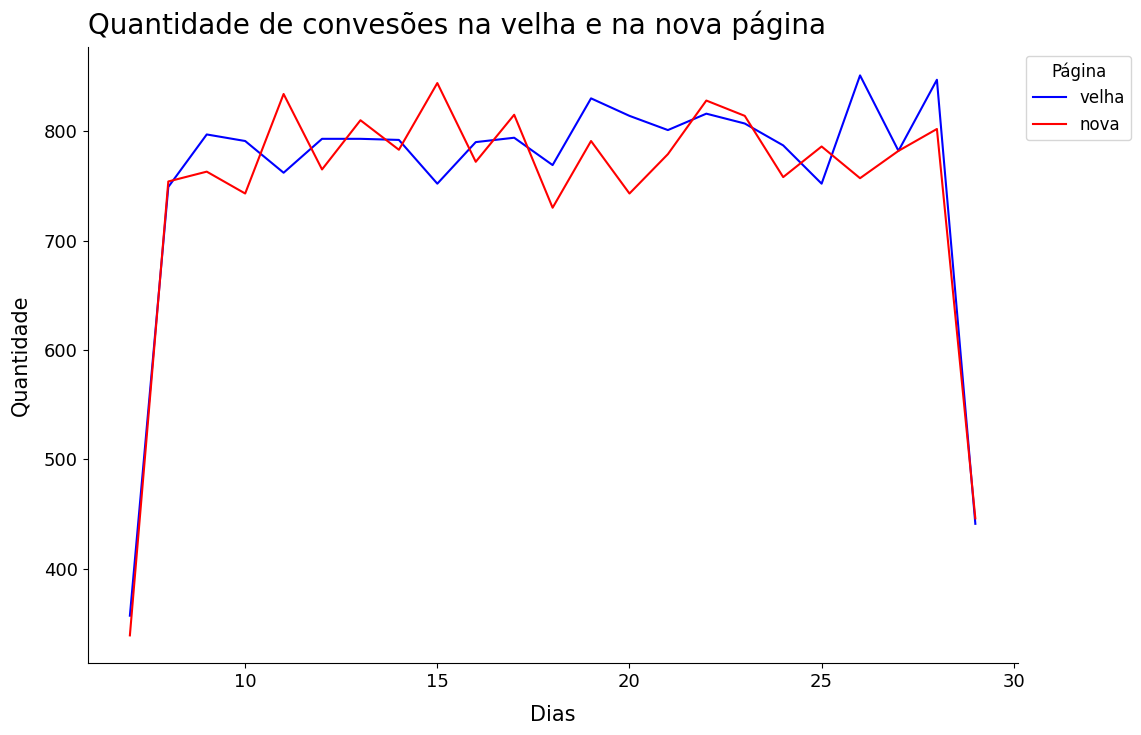

In [422]:
fig, ax = plt.subplots(figsize=(12,8))

ax = sns.lineplot(conversao_dados, x='Dia', y='count', palette=['blue', 'red'], hue='landing_page')

ax.set_title('Quantidade de convesões na velha e na nova página', fontsize=20, loc='left', pad=10)

ax.set_xlabel('Dias', fontsize=15, labelpad=10)
ax.xaxis.set_ticklabels([5, 10, 15, 20, 25, 30], fontsize=13)

ax.set_ylabel('Quantidade', fontsize=15, labelpad=10)
ax.yaxis.set_tick_params(labelsize=13)

ax.legend(bbox_to_anchor=(1, 1), title='Página', title_fontsize=12, fontsize=12)

sns.despine()

plt.show()

Vemos ao longo dos 30 dias, tivemos momentos de alta e momentos de baixa comparado as duas páginas. Vemos que é muito difícil dizer se estamos de fato tendo uma mudança com ou sem o modelo, mas tudo indica que não há mudança entre eles. (Atenção, as datas do gráfico não correspondem ao que está registrado nos dados, novamente, estamos apenas simulando.)

Precisamos realizar um teste bicaudal para ver se há alguma diferença entre eles.

## **Teste de Hipótese**

Por fim, realizaremos um teste A/B para validar finalmente nosso modelo, mais especificamente faremos um teste bicaudal, para validar se há alguma diferença entre eles. Tomaremos nossas primeiras hipótes, dependendo do que for verdade faremos mais.

### **H0:** Não há diferença na quantidade de conversões entre o site com ou sem nosso modelo.
### **H1:** Há uma diferença entre a quantidade de conversões.

Aqui estaremos preparando nossos dados para a análise, note que vamos pegar amostras entre os sites, ver a quantidade total em cada um e comparar a porcentagem entre conversão ou não de uma página com sua amostra, para verifica se não estamos tomando amostras que gerarão um grande erro.

In [414]:
df_novo = df.query('landing_page == "new_page"')
df_velho = df.query('landing_page == "old_page"')

amostra_novo = df_novo[['converted']].sample(n=5000, random_state=32)
amostra_velho = df_velho[['converted']].sample(n=5000, random_state=32)

In [415]:
print('Quantidade total do site novo\n', df_novo['converted'].value_counts(),'\n')

print('Porcentagem do site novo\n', df_novo['converted'].value_counts(normalize=True),'\n')

print('Porcentagem da amostra do site novo\n', amostra_novo['converted'].value_counts(normalize=True))

Quantidade total do site novo
 converted
0    128003
1     17238
Name: count, dtype: int64 

Porcentagem do site novo
 converted
0    0.881315
1    0.118685
Name: proportion, dtype: float64 

Porcentagem da amostra do site novo
 converted
0    0.8826
1    0.1174
Name: proportion, dtype: float64


In [416]:
print('Quantidade total do site velho\n', df_velho['converted'].value_counts(),'\n')

print('Porcentagem do site velho\n', df_velho['converted'].value_counts(normalize=True),'\n')

print('Porcentagem da amostra do site velho\n', amostra_velho['converted'].value_counts(normalize=True))

Quantidade total do site velho
 converted
0    127774
1     17467
Name: count, dtype: int64 

Porcentagem do site velho
 converted
0    0.879738
1    0.120262
Name: proportion, dtype: float64 

Porcentagem da amostra do site velho
 converted
0    0.8742
1    0.1258
Name: proportion, dtype: float64


Vemos novamente a proximidade da quantidade de pessoas entre as páginas e vemos que nossas amostras não fogem muito da porcentagem de pessoas que compraram ou não de seus respectivos sites. Mas mesmo com esse resultados, podemos ter um grande erro envolvido para nosso análise.

Por fim, como esse são dados que seguem um tendência binomial (apenas dois resultados possíveis), utilizaremos o *z-test* e o intervalo de confiança para dados da forma binomial. Queremos mostrar se há uma diferença entre os valores dos dados ou não, portanto faremos um teste bicaudal.

Começaremos separando os dados entre conversão e total e então aplicaremos ao teste para um significancia de 5%.

In [418]:
conversao = (amostra_novo['converted'].value_counts()[1], amostra_velho['converted'].value_counts()[1])
total = (amostra_novo['converted'].value_counts()[0], amostra_velho['converted'].value_counts()[0])

In [ ]:
from statsmodels.stats.proportion import proportions_ztest, confint_proportions_2indep

stat, pvalor = proportions_ztest(count=conversao, nobs=total, alternative='two-sided')
intervalo = confint_proportions_2indep(count1=conversao[0], nobs1=total[0], count2=conversao[1], nobs2=total[1])

print(f"Estatística do Z-score: {stat:.4f}")
print(f"P-valor do teste: {pvalor:.4f}")
print(f"Intevalo de Confiança: {(round(float(intervalo[0]),4), round(float(intervalo[1]),4))}")

Estatística do Z-score: -1.4772
P-valor do teste: 0.1396
Intevalo de Confiança: (-0.0253, 0.0036)


## **Conclusão**

Com um P-valor de 13,96%, temos que se assumirmos que as páginas são exatamente iguais (**H0**), a chance de encontrarmos uma flutuação do resultado tão extremo quanto esse é de 13,96%. Dessa forma não podemos rejeitar a hipótese nula (**H0**), ou por falta de dados ou porque não há de fato uma diferença.

Mas ao analisarmos o *Z-score* e o Intervalo de Confiança, vemos que mostra que estatisticamente o site sem o modelo foi relativamente melhor e que em casos extremos, o site sem o modelo foi 2,53% melhor que o site com o modelo e para o contrário, o site com o modelo seri 0,36% melhor que o site com o modelo.

No final, com o gráfico de linhas que plotamos, não podemos afirmar que o modelo ajudou a melhorar as vendas do site. Vemos que há uma grande variação entre os dias, com altas e baixas muitas vezes, mas com a antiga página se sobressaindo, assim como mostra tanto nos gráficos quanto nas estatísticas. Portanto nosso modelo não melhorou as vendas do site.